SETUP

In [1]:
import cv2
import datetime
from matplotlib import pyplot as plt
import os
from pathlib import Path

In [2]:
from hold_detection.detectron.HoldSegmentator import HoldSegmentator
from hold_matching.HoldMatcher import HoldMatcher
from pose_estimation.yolov7.ClimberPoseEstimator import ClimberPoseEstimator
from climbing_analysis.ClimbingAnalyzer import ClimbingAnalyzer
from smear_beta_utils.config import load_config
from smear_beta_utils.detectron_utils import plot_predictions

GLOBAL CONFIG

In [3]:
global_config, local_config = load_config()

In [4]:
image_file_name = "test_set\\PXL_20230412_192551425.MP.jpg"
video_file_name = "pose_estimation_2.mp4"
model_config_file_name = "hold-detector_cfg.pickle"
run_foldername = datetime.datetime.now().strftime("%Y%m%d%H%M")
save_path = str(
    Path(local_config["PATH"]["runs_output"]).joinpath(
        run_foldername
    )
)

In [5]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [7]:
analysis_start_frame = 350
analysis_end_frame = 960
# analysis_start_frame_1 = 350
# analysis_end_frame_1 = 1360
# analysis_start_frame_4 = 270
# analysis_end_frame_4 = 940
# analysis_start_frame_3 = 300
# analysis_end_frame_3 = 730
scale_factor = 1

READ DATA

In [13]:
image = cv2.imread(
    str(Path(local_config['PATH']['raw_routes']).joinpath(image_file_name))
)
image = cv2.resize(image, (0, 0), fx=0.75, fy=0.75)
image_height = image.shape[0]
image_width = image.shape[1]

In [14]:
frames = []
cap = cv2.VideoCapture(
    str(Path(local_config['PATH']['raw_videos']).joinpath(video_file_name))
)
while(cap.isOpened):
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        break
cap.release()

SELECT ANALYSIS HOLDS FROM IMAGE

In [15]:
def click_event(event, x, y, flags, param):
    global selected_holds_ids
    global image_predictions
    global plotted_image
    if event == cv2.EVENT_LBUTTONDOWN:
        # loop over each instance
        for index in range(len(image_predictions["instances"])):
            # get the bounding box coordinates
            x1, y1, x2, y2 = (
                image_predictions["instances"][index]
                .get("pred_boxes")
                .tensor
                .cpu()
                .tolist()[0]
            )
            if x > x1 and x < x2 and y > y1 and y < y2:
                selected_holds_ids.append(index)
                
        plotted_image = plot_predictions(
            image.copy(),
            image_predictions["instances"][selected_holds_ids],
        )
        cv2.imshow("image", cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB))

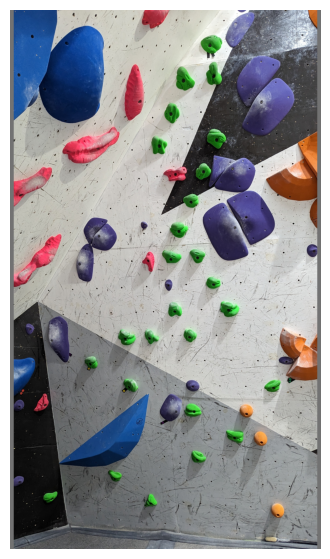

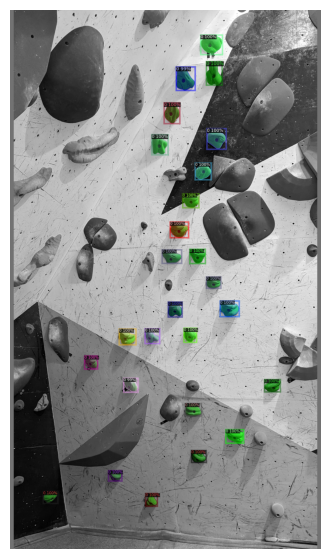

In [16]:
image_detector = HoldSegmentator(
    str(Path(local_config['PATH']['config']).joinpath(model_config_file_name)),
    str(Path(local_config['PATH']['hold_segmentation_models']).joinpath(
        local_config['RUNTIME']['hold_detector_model'])
    ),
    0.9,
    0.2
)
image, image_predictions = image_detector.predict(image, scale_factor=scale_factor)
selected_holds_ids = []
plotted_image = plot_predictions(
    image.copy(),
    image_predictions["instances"]
)
filename = "ref_image_detected_holds.jpg"
fig = plt.figure(figsize=(12,7))
plt.axis('off')
plt.imshow(plotted_image)
fig.savefig(
    str(
        Path(save_path).joinpath(filename)
    ),
    bbox_inches='tight',
    dpi=300
)

cv2.namedWindow("image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("image", 540, 960)
cv2.setMouseCallback("image", click_event)

plotted_image = plot_predictions(
    image.copy(),
    image_predictions["instances"][selected_holds_ids]
)
cv2.imshow("image", cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB))

while True:
    # Press 'q' to quit after selecting instances
    if cv2.waitKey(0) & 0xFF == ord("q"):
        break
cv2.destroyAllWindows()

plotted_image = plot_predictions(
    image.copy(),
    image_predictions["instances"][selected_holds_ids],
    color_mode="IMAGE_BW"
)
filename = "chosen_holds.jpg"
fig = plt.figure(figsize=(12,7))
plt.axis('off')
plt.imshow(plotted_image)
fig.savefig(
    str(
        Path(save_path).joinpath(filename)
    ),
    bbox_inches='tight',
    dpi=300
)

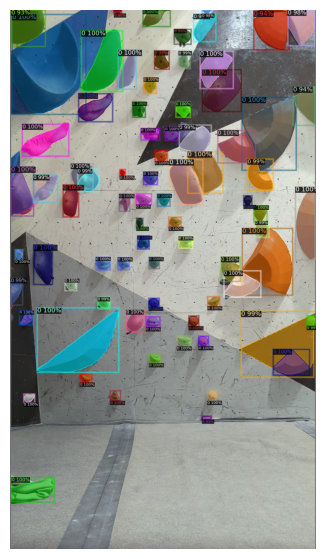

In [17]:
initial_frame = frames[0].copy()

video_detector = HoldSegmentator(
    str(Path(local_config['PATH']['config']).joinpath(model_config_file_name)),
    str(Path(local_config['PATH']['hold_segmentation_models']).joinpath(
        local_config['RUNTIME']['hold_detector_model'])
    ),
    0.7,
    0.5
)
initial_frame, video_predictions = video_detector.predict(
    frames[0],
    scale_factor=scale_factor
)

filename = "frame_detected_holds.jpg"
plotted_frame = plot_predictions(
    initial_frame.copy(),
    video_predictions["instances"]
)
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(plotted_frame)
fig.savefig(
    str(
        Path(save_path).joinpath(filename)
    ),
    bbox_inches='tight',
    dpi=300
)

MATCH HOLDS BETWEEN IMAGE AND FIRST FRAME

In [20]:
matcher = HoldMatcher()
matched_holds_ids = matcher.match(
    image,
    initial_frame,
    image_predictions,
    video_predictions,
    selected_holds_ids,
    color_range_degrees=10,
    color_range_match_score=20,
)

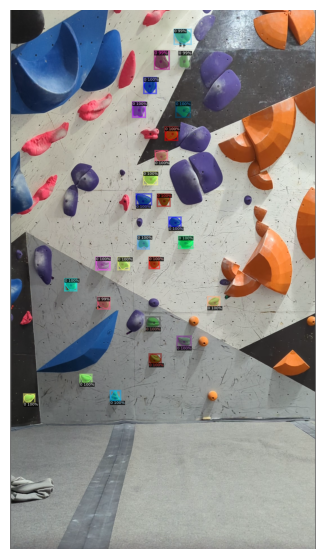

In [21]:
%matplotlib inline

plotted_frame = plot_predictions(
    initial_frame.copy(),
    video_predictions["instances"][matched_holds_ids]
)
filename = "frame_matched_holds.jpg"
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(plotted_frame)
fig.savefig(
    str(
        Path(save_path).joinpath(filename)
    ),
    bbox_inches='tight',
    dpi=300
)

OBTAIN POSE ESTIMATION

In [22]:
pose_estimation_model = "yolov7-w6-pose.pt"
pose_estimation_model_path = (
    str(
        Path(
            local_config["PATH"]["yolov7_pose_estimation_models"]
        ).joinpath(pose_estimation_model)
    )
)
yolov7_repository_path = (
    global_config["PATH"]["source"]+"yolov7\\"
)

frames_analysis_section = frames[analysis_start_frame:analysis_end_frame]

In [24]:
pose_estimator = ClimberPoseEstimator(
    pose_estimation_model_path,
    yolov7_repository_path,
)
pose_estimator.estimate_pose(
    frames_analysis_section,
    scale_factor=scale_factor,
    save_result=True,
    save_path=save_path,
)
pose_estimator.estimate_significant_frames(
    save_significant_frames_figure=True,
    save_path=save_path,
)
output = pose_estimator.get_estimator_output()

PERFORM ANALYSIS

In [31]:
analyzer = ClimbingAnalyzer(
    video_predictions,
    matched_holds_ids
)
analyzer.analyze(
    output,
    save_results=True,
    save_path=save_path,
    frames=frames_analysis_section,
)